# Análise dos Resultados da Previsão de Engajamento - Classificação

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from util import load_results, filter_dataset

In [2]:
# show sklearn version
import sklearn
sklearn.__version__

'1.6.1'

In [3]:
BASE_PATH = 'dados/preprocessed/'
EMBEDDING_MODEL = 'paraphrase-multilingual-MiniLM'
SOCIAL_NETWORK = 'tiktok'

# 1 - Carregando Dados

### Altere Aqui

In [4]:
RESULTS_FILE_PATH = "resultados/resultados50p_2025-04-03-16h16m_bolsonaro(mxbai-embed-large-v1)_(tiktok).npy"  # TODAS as features
#RESULTS_FILE_PATH = "resultados/resultados50p_2025-04-03-15h53m_bolsonaro(mxbai-embed-large-v1)_(tiktok).npy"  # usa APENAS os embeddings

Carregando os dados dos resultados.

In [5]:
metadata, results = load_results(RESULTS_FILE_PATH)

In [6]:
metadata

{'date': '2025-04-03-16h16m',
 'subdataset': 'bolsonaro',
 'dropped_features': [],
 'target': 'Curtidas-2Classes-50p',
 'random_state': 1231,
 'description': 'Treinamento com \n    - dados balanceados (50p) \n    - dataset bolsonaro\n    - com todos os modelos, incluindo novos ensembles (sem vazamento?)\n    - deixando todas as features\n    - tentativas de ajustar a opções de parâmetros da random forest (testando valores para class_weight)\n',
 'basic_models': ['Random Forest'],
 'cv_outer': RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=1231),
 'cv_inner': StratifiedKFold(n_splits=5, random_state=None, shuffle=True)}

In [7]:
print(metadata['description'])

Treinamento com 
    - dados balanceados (50p) 
    - dataset bolsonaro
    - com todos os modelos, incluindo novos ensembles (sem vazamento?)
    - deixando todas as features
    - tentativas de ajustar a opções de parâmetros da random forest (testando valores para class_weight)



In [8]:
metadata['dropped_features']

[]

Carregando dados brutos.

In [9]:
dfx_full = pd.read_excel(f"{BASE_PATH}full-preproc2-inputs_{EMBEDDING_MODEL}_{SOCIAL_NETWORK}.xlsx", index_col='ID')
dfy_full = pd.read_excel(f"{BASE_PATH}full-preproc2-outputs_{EMBEDDING_MODEL}_{SOCIAL_NETWORK}.xlsx", index_col='ID')

In [10]:
dfx, dfy = filter_dataset(dfx_full, dfy_full, metadata)

Dataset BOLSONARO (indicador 0)


In [11]:
dfx.columns

Index(['Only Hashtags', 'Dias Decorridos', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6',
       'x7', 'x8',
       ...
       'x375', 'x376', 'x377', 'x378', 'x379', 'x380', 'x381', 'x382', 'x383',
       'x384'],
      dtype='object', length=386)

In [12]:
BASIC_MODEL_NAMES = metadata['basic_models']
BASIC_MODEL_NAMES

['Random Forest']

In [13]:
TOTAL_SPLITS = metadata['cv_outer'].get_n_splits()
TOTAL_SPLITS

5

# 2 - Métricas Principais

In [14]:
from ipywidgets import interact

In [15]:
# Modelos disponíveis (básicos e ensemble)
print("Modelos testados:")
results.keys()

Modelos testados:


dict_keys(['Random Forest', 'FOLD_00-hard-vote', 'FOLD_00-soft-vote', 'FOLD_01-hard-vote', 'FOLD_01-soft-vote', 'FOLD_02-hard-vote', 'FOLD_02-soft-vote', 'FOLD_03-hard-vote', 'FOLD_03-soft-vote', 'FOLD_04-hard-vote', 'FOLD_04-soft-vote', 'Best-hard-vote', 'Best-soft-vote'])

In [16]:
METRICS = [
    'f1_score_mean', 'f1_score_std', 
    'precision_mean', 'precision_std', 
    'recall_mean', 'recall_std', 
    'accuracy_mean', 'accuracy_std', 
    'auc_roc_mean', 'auc_roc_std', 
    'auc_pr_mean', 'auc_pr_std'
]

In [17]:
df_result = pd.DataFrame(results).T
df_result = df_result[METRICS]

## 2.1 - Modelos Básicos

Resultados ordenados pelo F1-score.

In [18]:
df_result.loc[df_result.index.isin(BASIC_MODEL_NAMES), :].sort_values('f1_score_mean', ascending=False)

,f1_score_mean,f1_score_std,precision_mean,precision_std,recall_mean,recall_std,accuracy_mean,accuracy_std,auc_roc_mean,auc_roc_std,auc_pr_mean,auc_pr_std
Random Forest,0.705677,0.038033,0.612467,0.045617,0.838462,0.070501,0.65,0.052172,0.704438,0.035164,0.685634,0.045061


## 2.2 - Todos os Modelos

In [19]:
def order_models_by(order_by):
    display(df_result.sort_values(by=order_by, ascending=False))
    return

interact(order_models_by, order_by=METRICS);

interactive(children=(Dropdown(description='order_by', options=('f1_score_mean', 'f1_score_std', 'precision_me…

## 2.3 - Classificador Aleatório (para comparação)

In [20]:
from classification_util import random_classifier_results

In [21]:
CLASSIFIER_TRUE_PROB = 0.5

rand_results = random_classifier_results(dfy, classifier_true_prob=CLASSIFIER_TRUE_PROB, trials=100)

print(f"RANDOM CLASSIFIER ({100*CLASSIFIER_TRUE_PROB:.0f}% chance for class 1)")
print(f" - F1-Score   : {rand_results['f1_score_mean']:.4f} +/- {rand_results['f1_score_std']:.4f}")
print(f" - Acurácia   : {rand_results['accuracy_mean']:.4f} +/- {rand_results['accuracy_std']:.4f}")
print(f" - Precisão   : {rand_results['precision_mean']:.4f} +/- {rand_results['precision_std']:.4f}")
print(f" - Revocação  : {rand_results['recall_mean']:.4f} +/- {rand_results['recall_std']:.4f}")
print(f" - AUC ROC    : {rand_results['auc_roc_mean']:.4f} +/- {rand_results['auc_roc_std']:.4f}")
print(f" - AUC PR     : {rand_results['auc_pr_mean']:.4f} +/- {rand_results['auc_pr_std']:.4f}")
print('=' * 50, '\n')

RANDOM CLASSIFIER (50% chance for class 1)
 - F1-Score   : 0.5048 +/- 0.0331
 - Acurácia   : 0.5055 +/- 0.0299
 - Precisão   : 0.5055 +/- 0.0300
 - Revocação  : 0.5050 +/- 0.0420
 - AUC ROC    : 0.5000 +/- 0.0000
 - AUC PR     : 0.5000 +/- 0.0000



# 3 - Melhores Hiper-Parâmetros

### 3.1 - Valores de parâmetros mais frequentes entre os melhores, por modelo

In [22]:
from collections import Counter

def aggregate_best_params(model_name):
    best_params_list = results[model_name]['best_parameters']
    
    # for each name of parameter, counts the number of times each of its value appeared among the best
    params_count = dict()

    for param_name in best_params_list[0].keys():
        # fora each value of the parameter, counts the occurences
        params_count[param_name] = Counter()
        
        for params in best_params_list:
            param_value = params[param_name]
            if type(param_value) == dict:
                param_value = str(param_value)
            params_count[param_name][param_value] += 1
    
    display(params_count)

#aggregate_best_params('Logistic Regression')
interact(aggregate_best_params, model_name=BASIC_MODEL_NAMES)

interactive(children=(Dropdown(description='model_name', options=('Random Forest',), value='Random Forest'), O…

<function __main__.aggregate_best_params(model_name)>

### 3.2 - Melhor modelo *básico* por fold (e seus hiperparâmetros)

In [23]:
def list_best_model_per_fold():
    for fold in range(TOTAL_SPLITS):   
        best_f1 = 0.0
        best_model_params = None
        best_model_name = None
        for model_name in BASIC_MODEL_NAMES:
            if results[model_name]['f1_score_list'][fold] > best_f1:
                best_f1 = results[model_name]['f1_score_list'][fold]
                best_model_params = results[model_name]['best_parameters'][fold]
                best_model_name = model_name
        
        print(f"FOLD {fold} - best model is a '{best_model_name}' with hiper-parameters:")
        if best_model_params is not None:
            for key in best_model_params:
                if key is not None:
                    print(f" - {key}: {best_model_params[key]}")
        print(f" - F1 score: {results[best_model_name]['f1_score_list'][fold]:.4f}")

list_best_model_per_fold()

FOLD 0 - best model is a 'Random Forest' with hiper-parameters:
 - pca: PCA(n_components=10)
 - predictor__class_weight: {0: 1.0, 1: 2.0}
 - predictor__max_depth: 4
 - predictor__min_samples_split: 8
 - predictor__n_estimators: 70
 - F1 score: 0.7018
FOLD 1 - best model is a 'Random Forest' with hiper-parameters:
 - pca: PCA(n_components=20)
 - predictor__class_weight: {0: 1.0, 1: 2.0}
 - predictor__max_depth: 2
 - predictor__min_samples_split: 4
 - predictor__n_estimators: 10
 - F1 score: 0.6349
FOLD 2 - best model is a 'Random Forest' with hiper-parameters:
 - pca: PCA(n_components=20)
 - predictor__class_weight: {0: 1.0, 1: 2.0}
 - predictor__max_depth: 4
 - predictor__min_samples_split: 10
 - predictor__n_estimators: 10
 - F1 score: 0.7458
FOLD 3 - best model is a 'Random Forest' with hiper-parameters:
 - pca: PCA(n_components=10)
 - predictor__class_weight: {0: 1.0, 1: 2.0}
 - predictor__max_depth: 4
 - predictor__min_samples_split: 10
 - predictor__n_estimators: 30
 - F1 score: 0

### 3.3 - Melhores hiperparâmetros de cada modelo (em todos os folds)

Observação: A seção 3.1 mostra esta informação de forma mais condensada.

In [24]:
def list_all_best_params(model_name):
    best_params_list = results[model_name]['best_parameters']
    for i, paramset in enumerate(best_params_list):
        print("BEST PARAM SET IN FOLD", i, ":")
        for key in paramset.keys():
            print(f" - {key}: {paramset[key]}")
        print(f" - F1 score: {results[model_name]['f1_score_list'][i]:.4f}")


#list_all_best_params('Logistic Regression')
#list_all_best_params('Random Forest')
#list_all_best_params('Support Vector Machine')

interact(list_all_best_params, model_name=BASIC_MODEL_NAMES)

interactive(children=(Dropdown(description='model_name', options=('Random Forest',), value='Random Forest'), O…

<function __main__.list_all_best_params(model_name)>

# 4 - Curvas ROC e PR

In [25]:
from classification_util import plot_roc_curve, plot_pr_curve

In [26]:
def plot_model_roc_curves(model_name, overlapped=True):
    if overlapped:
        # Plot ROC curves for all folds in a single plot
        plt.figure(figsize=(10, 6))
        for fold in range(TOTAL_SPLITS):
            plot_roc_curve(results, model_name=model_name, fold=fold, show_plot=False, plot_ref_line=False)
        plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
        plt.legend(loc='lower right')
        plt.title(f'Curva ROC - {model_name} (Overlapped)')
    
    else:
        # Calculate the number of rows needed for two columns
        n_rows = (TOTAL_SPLITS + 1) // 2

        # Create a figure with subplots arranged in two columns
        fig, axes = plt.subplots(n_rows, 2, figsize=(10, 4 * n_rows))  # Adjust width and height

        # Flatten the axes array for easier indexing
        axes = axes.flatten()

        # Plot each fold's ROC curve
        for fold in range(TOTAL_SPLITS):
            ax = axes[fold]
            plt.sca(ax)  # Set current axis
            plot_roc_curve(results, model_name=model_name, fold=fold, show_plot=False, plot_ref_line=True)
            ax.set_title(f'Curva ROC - {model_name} (Fold {fold + 1})')

        # Hide any unused subplots
        for i in range(TOTAL_SPLITS, len(axes)):
            axes[i].axis('off')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the combined plot
    plt.show()

interact(plot_model_roc_curves, model_name=results.keys(), overlapped=[True, False])

interactive(children=(Dropdown(description='model_name', options=('Random Forest', 'FOLD_00-hard-vote', 'FOLD_…

<function __main__.plot_model_roc_curves(model_name, overlapped=True)>

In [27]:
def plot_model_pr_curves(model_name, overlapped=True):
    if overlapped:
        # Plot ROC curves for all folds in a single plot
        plt.figure(figsize=(10, 6))
        for fold in range(TOTAL_SPLITS):
            plot_pr_curve(results, model_name=model_name, fold=fold, show_plot=False)
        plt.legend(loc='lower right')
        plt.title(f'Curva PR - {model_name} (Overlapped)')
    
    else:
        # Calculate the number of rows needed for two columns
        n_rows = (TOTAL_SPLITS + 1) // 2

        # Create a figure with subplots arranged in two columns
        fig, axes = plt.subplots(n_rows, 2, figsize=(10, 4 * n_rows))  # Adjust width and height

        # Flatten the axes array for easier indexing
        axes = axes.flatten()

        # Plot each fold's ROC curve
        for fold in range(TOTAL_SPLITS):
            ax = axes[fold]
            plt.sca(ax)  # Set current axis
            plot_pr_curve(results, model_name=model_name, fold=fold, show_plot=False)
            ax.set_title(f'Curva PR - {model_name} (Fold {fold + 1})')

        # Hide any unused subplots
        for i in range(TOTAL_SPLITS, len(axes)):
            axes[i].axis('off')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the combined plot
    plt.show()

interact(plot_model_pr_curves, model_name=results.keys(), overlapped=[True, False])

interactive(children=(Dropdown(description='model_name', options=('Random Forest', 'FOLD_00-hard-vote', 'FOLD_…

<function __main__.plot_model_pr_curves(model_name, overlapped=True)>

# 5 - Importâncias dos Atributos


- Baseado nos valores de `feature_importances_` calculados em alguns modelos

In [28]:
#@title Definições auxiliares (não precisa abrir)
from sklearn.tree import plot_tree


def plot_importance(importances, title=None, max_features=None, feature_names=None, sort=True, ax=None):
    """
    Plot feature importances for a scikit-learn random forest or gradient boosting model.

    Parameters
    ----------
    model : object
        A scikit-learn random forest or gradient boosting model.
    title: str or None, optional (default=None)
        The title of the plot.
    max_features : int or None, optional (default=None)
        The maximum number of features to plot. If None, plot all features.
    feature_names : list or None, optional (default=None)
        A list of feature names to use in the plot. If None, use the feature indices.
    sort : bool, optional (default=True)
        Whether to sort the feature importances in descending order.
    ax : matplotlib.axes.Axes or None, optional (default=None)
        The matplotlib axes to plot the feature importances on. If None, create a new figure and axes.

    Returns
    -------
    ax : matplotlib.axes.Axes
        The matplotlib axes containing the plot.

    """
    # Extract feature importances
    #importances = model.feature_importances_

    # Get feature names
    if feature_names is None:
        feature_names = [str(i) for i in range(len(importances))]

    # Sort feature importances
    if sort:
        indices = np.argsort(importances)[::-1]
        importances = importances[indices]
        feature_names = [feature_names[i] for i in indices]

    # Truncate feature importances
    if max_features is not None:
        importances = importances[:max_features]
        feature_names = feature_names[:max_features]

    # Create plot
    if ax is None:
        fig, ax = plt.subplots()
   
    if title:
        ax.set_title(title, fontsize=12)

    ax.barh(np.arange(len(importances)), importances, align='center')
    ax.set_yticks(np.arange(len(importances)))
    ax.set_yticklabels(feature_names)
    #ax.set_xlabel('Gini importance', fontsize=10)
    ax.invert_yaxis()

    return ax

Mostras as importâncias para CADA uma das configurações ótimas (1 por outer fold) do modelo

In [29]:
from sklearn import clone

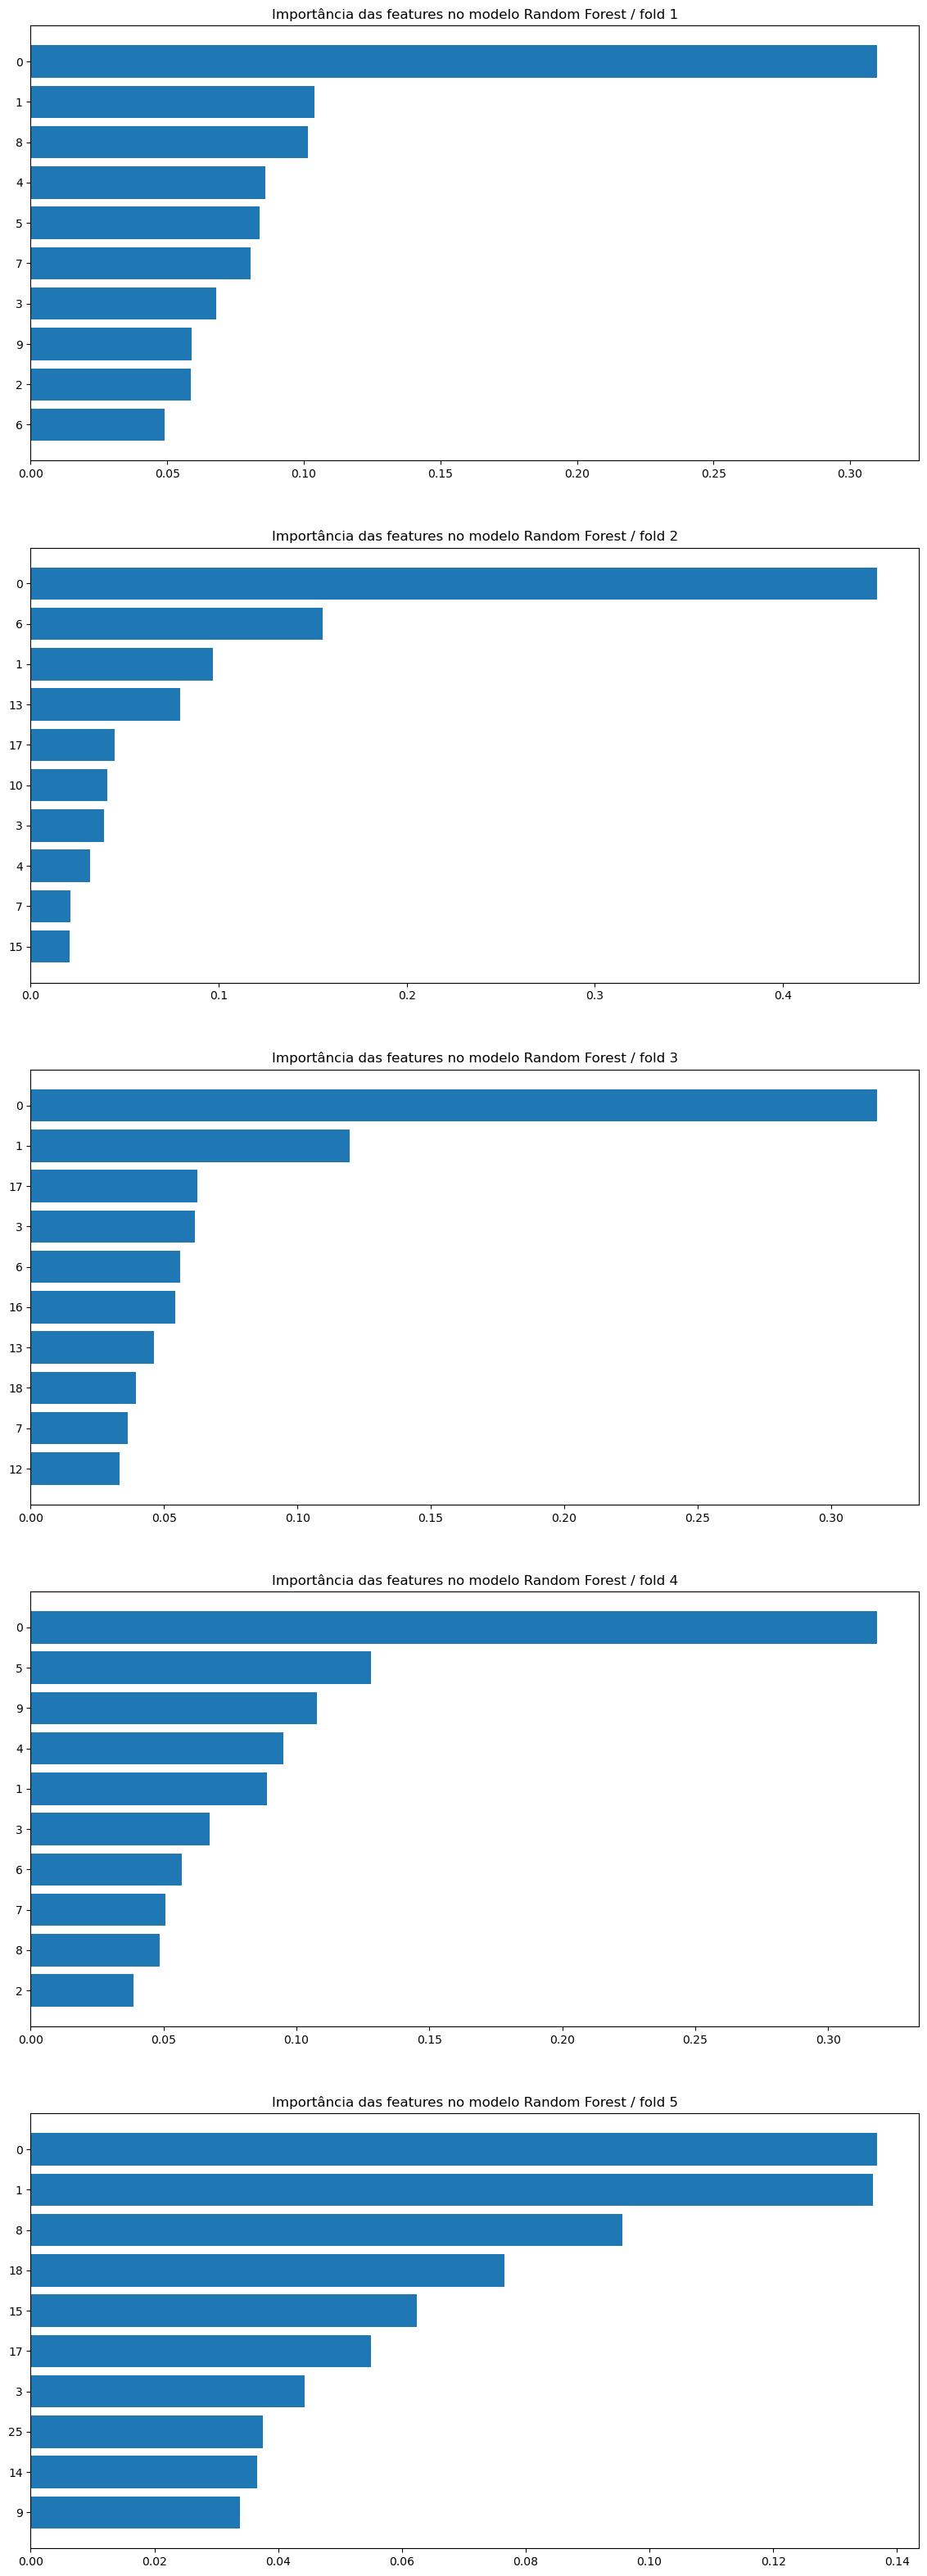

In [30]:
for model_name in results.keys():
    if 'vote' in model_name:
        continue

    model_pipeline = results[model_name]['best_models'][0]  # the best model found in the first fold
    model_predictor = model_pipeline.named_steps['predictor']

    # testa se o modelo guarda as importâncias das features
    if not hasattr(model_predictor, 'feature_importances_'):
        print(f"O modelo {model_name} não registra as importâncias das features")
        continue

    fig, axs = plt.subplots(TOTAL_SPLITS, 1, figsize=(14, 8 * TOTAL_SPLITS))
    
    # Configurando a validação cruzada externa (igual à da função de treinamento)
    cv_outer = metadata['cv_outer']

    fold = 0
    for train_ix, test_ix in cv_outer.split(dfx, dfy):
        X_train = dfx.iloc[train_ix]
        y_train = dfy.iloc[train_ix]

        model_pipeline = results[model_name]['best_models'][fold]
        model_predictor = model_pipeline.named_steps['predictor']
        
        model_pipeline.fit(X_train, y_train)

        #features_names = model_pipeline.named_steps['preproc'].get_feature_names_out()
        features_names = None
        importances = model_predictor.feature_importances_
        plot_importance(importances, 
                        title=f"Importância das features no modelo {model_name} / fold {fold+1}", 
                        feature_names=features_names, 
                        max_features=10, 
                        ax=axs[fold])
        fold += 1

In [31]:
# Features identificadas nos gráficos acima como a mais importante de cada fold (ordenadas pelo fold)
#important_pca_features = [3, 17, 3, 0, 0]
important_pca_features = [0, 0, 0, 0, 0]

for fold, feature in enumerate(important_pca_features):
    print(f"\nFOLD {fold}")
    random_forest_pipeline = results['Random Forest']['best_models'][fold]
    
    pca = random_forest_pipeline.named_steps['pca']
    print(f"number of components: {pca.n_components_}")
    print(f"total explained variance: {np.sum(pca.explained_variance_):.3f}") ## ??
    print(f"most important pca-generated feature: #{feature}")
    
    print(f"composition of pca-generated feature #{feature} (top 10 original features of highest absolute weights)")
    indices = np.argsort(np.abs(pca.components_[feature]))[::-1][:10]
    for i in indices:
        print(f" - {dfx.columns[i]}: {pca.components_[feature][i]:.4f}")


FOLD 0
number of components: 10
total explained variance: 875.373
most important pca-generated feature: #0
composition of pca-generated feature #0 (top 10 original features of highest absolute weights)
 - Dias Decorridos: 0.9999
 - Only Hashtags: 0.0023
 - x202: 0.0021
 - x272: -0.0016
 - x173: 0.0013
 - x252: -0.0013
 - x133: -0.0013
 - x42: -0.0013
 - x60: -0.0013
 - x259: 0.0013

FOLD 1
number of components: 20
total explained variance: 915.580
most important pca-generated feature: #0
composition of pca-generated feature #0 (top 10 original features of highest absolute weights)
 - Dias Decorridos: 1.0000
 - Only Hashtags: 0.0024
 - x202: 0.0018
 - x272: -0.0015
 - x173: 0.0015
 - x120: 0.0013
 - x133: -0.0013
 - x356: 0.0012
 - x252: -0.0011
 - x73: -0.0011

FOLD 2
number of components: 20
total explained variance: 915.580
most important pca-generated feature: #0
composition of pca-generated feature #0 (top 10 original features of highest absolute weights)
 - Dias Decorridos: 1.000

-----

# FIM